# MATH 484 Linear Programs and Related Problems

MATH 484 Linear Programs and Related Problems

The Pennsylvania State University

Based on Prof. Christopher Byrne's lecture materials and his _Linear Programs I: A Clear, Concise, and Practical Introduction to Linear Programs and Duality Theory with Applications to Return On Investment (ROI)_.

---

## Imports & Environment

In [71]:
import numpy                    as np
import numpy.random             as npr
import pandas                   as pd

import matplotlib               as mpl
import matplotlib.pyplot        as plt
plt.style.use('ggplot');

import sympy                    as sy
from   sympy.geometry import Point, Line

import numexpr

from   datetime import datetime as d
import locale                   as l
import platform                 as p
import sys                      as s

pad = 20
print(f"{'Executed'.upper():<{pad}}: {d.now()}")
print()
print(f"{'Platform'        :<{pad}}: "
      f"{p.mac_ver()[0]} | "
      f"{p.system()} | "
      f"{p.release()} | "
      f"{p.machine()}")
print(f"{''                :<{pad}}: {l.getpreferredencoding()}")
print()
print(f"{'Python'          :<{pad}}: {s.version}")
print(f"{''                :<{pad}}: {s.version_info}")
print(f"{''                :<{pad}}: {p.python_implementation()}")
print()
print(f"{'Matplotlib'      :<{pad}}: {mpl.__version__}")
print(f"{'Numexpr'         :<{pad}}: {numexpr.__version__}")
print(f"{'NumPy'           :<{pad}}: {np.__version__}")
print(f"{'Pandas'          :<{pad}}: {pd.__version__}")
print(f"{'SymPy'           :<{pad}}: {sy.__version__}")

EXECUTED            : 2023-02-01 11:09:22.747884

Platform            : 13.1 | Darwin | 22.2.0 | arm64
                    : UTF-8

Python              : 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:29) [Clang 14.0.6 ]
                    : sys.version_info(major=3, minor=10, micro=8, releaselevel='final', serial=0)
                    : CPython

Matplotlib          : 3.6.3
Numexpr             : 2.8.3
NumPy               : 1.24.1
Pandas              : 1.5.3
SymPy               : 1.11.1


---

## Auxiliary

In [98]:
def intersect (a,b,c,d):
  l1=Line(Point(a),Point(b))
  l2=Line(Point(c),Point(d))
  intersection=l1.intersection(l2)[0]
  return sy.Float(intersection[0]),sy.Float(intersection[1])



def draw_constraint (yb,
                     delz,
                     delg,
                     dv,
                     dd,
                     i,
                     scale,
                     size,
                     lw=1,
                     c='b'):

  # print(f"{'Constraint':<20}{yb[0]}")
  # print(f"{'Gradient of obj':<20}{delz.flatten()}")
  # print(f"{'Gradient of con':<20}{delg.flatten()}")
  # print(f"{'Direction':<20}{dv.flatten()}")
  # print(f"{'DD':<20}{dd}")

  x=np.linspace(-scale,scale,size+1)
  y=numexpr.evaluate(yb[0])

  # compute the intersection
  #   line1 through origin and gradient
  #   line2 through y-intercept and x-intercept
  intersection=intersect(
    (0,0),
    delg.flatten(),
    (0,yb[1]),
    (dv.flatten()[0],dv.flatten()[1]+yb[1]),
  )
  
  # draw the point of intersection
  plt.scatter(*intersection,color=c);
  plt.text(*intersection,f'$g_{i+1}$');

  # draw the constraint gradient
  plt.quiver(*intersection,
             *delg.flatten()/np.sqrt(delg.flatten()[0]**2+delg.flatten()[1]**2),
             color=c,
             width=0.002,
             scale=50);

  # draw the gradient vector of the objective function
  plt.quiver(*intersection,
             *delz.flatten(),
             color='black',
             width=0.002,
             scale=100)

  if dd>0:
    plt.quiver(*intersection,
               *dv.flatten(),
               color=c,
               width=0.005);
    # plot the constraint boundary
    plt.plot(x,y,label=yb[2],color=c,linewidth=lw);
  elif dd<0:
    plt.quiver(*intersection,
               *(-dv.flatten()[0],-dv.flatten()[1]),
               color=c,
               width=0.005);
    # plot the constraint boundary
    plt.plot(x,y,label=yb[2],color=c,linewidth=lw);
  else:
    # plot the constraint boundary
    plt.plot(x,y,label=yb[2],color=c,linewidth=5*lw);



def draw_LP (constraints,
             scale=10,
             step =1,
             size =1000):

  plt.figure(figsize=(15,15));
  plt.axes().set_aspect(1)
  
  plt.xlim((-scale, scale));
  plt.xticks(np.arange(-scale, scale+step, step));
  plt.ylim((-scale, scale));
  plt.yticks(np.arange(-scale, scale+step, step));

  for i,constraint in enumerate(constraints):
    draw_constraint(*constraint,
                    i,
                    scale,
                    size,
                    c=npr.choice(list('rygbc')))

  x=np.linspace(-scale,scale,size+1)
  fx,fy=np.meshgrid(x,x)
  plt.imshow(
    (
      (numexpr.evaluate(constraints[0][0][3]))
    & (numexpr.evaluate(constraints[1][0][3]))
    & (numexpr.evaluate(constraints[2][0][3]))
    & (numexpr.evaluate(constraints[3][0][3]))
    ).astype(int),
    extent=(fx.min(),fx.max(),fy.min(),fy.max()),
    origin='lower',
    cmap  ='Greys',
    alpha =0.3,
  );

  # draw the origin
  plt.scatter(0,0,color='black');
  # draw the legend
  plt.xlabel('$x_1$');
  plt.ylabel('$x_2$');
  plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.);





def get_solution (delg_a, delg_b, gi_a, gi_b, delz, ac=None, opt='max'):
    """Determine and draw the solution, given the two intersecting lines which point to the optimal set."""
    
    # determine and draw the optimal set
    argmax_x1, argmax_x2 = get_intersection((0, gi_a), (delg_a[1], -delg_a[0] + gi_a), (0, gi_b), (delg_b[1], -delg_b[0] + gi_b))
    
    if opt=='max':
        plt.scatter(argmax_x1, argmax_x2, s=2*ps, color='k', zorder=100);
    elif opt=='min':
        plt.scatter(argmax_x1, argmax_x2, s=2*ps, color='w', zorder=100);
    
    # compute the optimal value
    if (ac != None):
        optZ = delz[0]*argmax_x1 + delz[1]*argmax_x2 + ac
    else:
        optZ = delz[0]*argmax_x1 + delz[1]*argmax_x2

---

\begin{align}
\text{max} \,\,\, 20x_1 + 10x_2 & \,\,\, \text{s.t.} \\
30x_1 + 10x_2 &\le 400 \\
 3x_1 +  4x_2 &\le  80 \\
          x_1 &\le  10 \\
          x_2 &\le  40 \\
     x_1, x_2 &\ge   0 \\
\end{align}

---

## Problems

---

1

LP

$$
\begin{align*}
\max Z(\mathbf{x})&=-3x_1+2x_2\\
g_1(\mathbf{x})&=-4x_1+7x_2&&\le28&&=b_1\\
g_2(\mathbf{x})&=-5x_1-2x_2&&\le10&&=b_2\\
g_3(\mathbf{x})&=-6x_1+4x_2&&\ge-12&&=b_3\\
g_4(\mathbf{x})&=-x_1-x_2&&\ge-8&&=b_4\\
\end{align*}
$$

$
\begin{aligned}
g_1(\mathbf{x})&=-4x_1+7x_2&&\le28&&=b_1\,\,\,\text{or}\,\,\,x_2\le\frac{4}{7}x_1+4\\
g_2(\mathbf{x})&=-5x_1-2x_2&&\le10&&=b_2\,\,\,\text{or}\,\,\,x_2\ge-\frac{5}{2}x_1-5\\
g_3(\mathbf{x})&=-6x_1+4x_2&&\ge-12&&=b_3\,\,\,\text{or}\,\,\,x_2\ge\frac{3}{2}x_1-3\\
g_4(\mathbf{x})&=-x_1-x_2&&\ge-8&&=b_4\,\,\,\text{or}\,\,\,x_2\le-x_1+8\\
\end{aligned}
$

$\nabla Z=\begin{bmatrix}-3\\2\\\end{bmatrix}$

$
\begin{aligned}
\nabla g_1&=\begin{bmatrix}-4\\7\\\end{bmatrix}\\
\nabla g_2&=\begin{bmatrix}-5\\-2\\\end{bmatrix}\\
\nabla g_3&=\begin{bmatrix}-6\\4\\\end{bmatrix}\\
\nabla g_4&=\begin{bmatrix}-1\\-1\\\end{bmatrix}\\
\end{aligned}
$

$
\begin{aligned}
v_1&=\begin{bmatrix}7\\4\\\end{bmatrix}&&\text{points NE}\\
v_2&=\begin{bmatrix}-2\\5\\\end{bmatrix}&&\text{points NW}\\
v_3&=\begin{bmatrix}4\\6\\\end{bmatrix}&&\text{points NE}\\
v_4&=\begin{bmatrix}-1\\1\\\end{bmatrix}&&\text{points NW}\\
\end{aligned}
$

$
\begin{aligned}
\nabla Z\cdot v_1&=-3\cdot7+2\cdot4&&\lt0&&\implies\text{SW maximization}\\
\nabla Z\cdot v_2&=-3\cdot-2+2\cdot5&&\gt0&&\implies\text{NW maximization}\\
\nabla Z\cdot v_3&=-3\cdot4+2\cdot6&&=0&&\implies\text{level set}\\
\nabla Z\cdot v_4&=-3\cdot-1+2\cdot1&&\gt0&&\implies\text{NW maximization}\\
\end{aligned}
$

argmax$_{\Gamma}(f)=\left\{\left(-\frac{126}{43},\frac{100}{43}\right)\right\}$<br>

$\frac{4}{7}x_1+4=-\frac{5}{2}x_1-5$<br>
$\frac{4}{7}x_1+\frac{5}{2}x_1=-5-4$<br>
$\frac{8}{14}x_1+\frac{35}{14}x_1=-9$<br>
$\frac{43}{14}x_1=-9$<br>
$x_1=(\frac{14}{43})(-9)=-\frac{126}{43}$<br>
$x_2=\frac{4}{7}(-\frac{126}{43})+4=-\frac{504}{301}+4=-\frac{72}{43}+\frac{172}{43}=\frac{100}{43}$

max$_{\Gamma}(f)=\frac{578}{43}=13.44$<br>

$-3x_1+2x_2=-3(-\frac{126}{43})+2(\frac{100}{43})=\frac{378}{43}+\frac{200}{43}=\frac{578}{43}=13.44$<br>

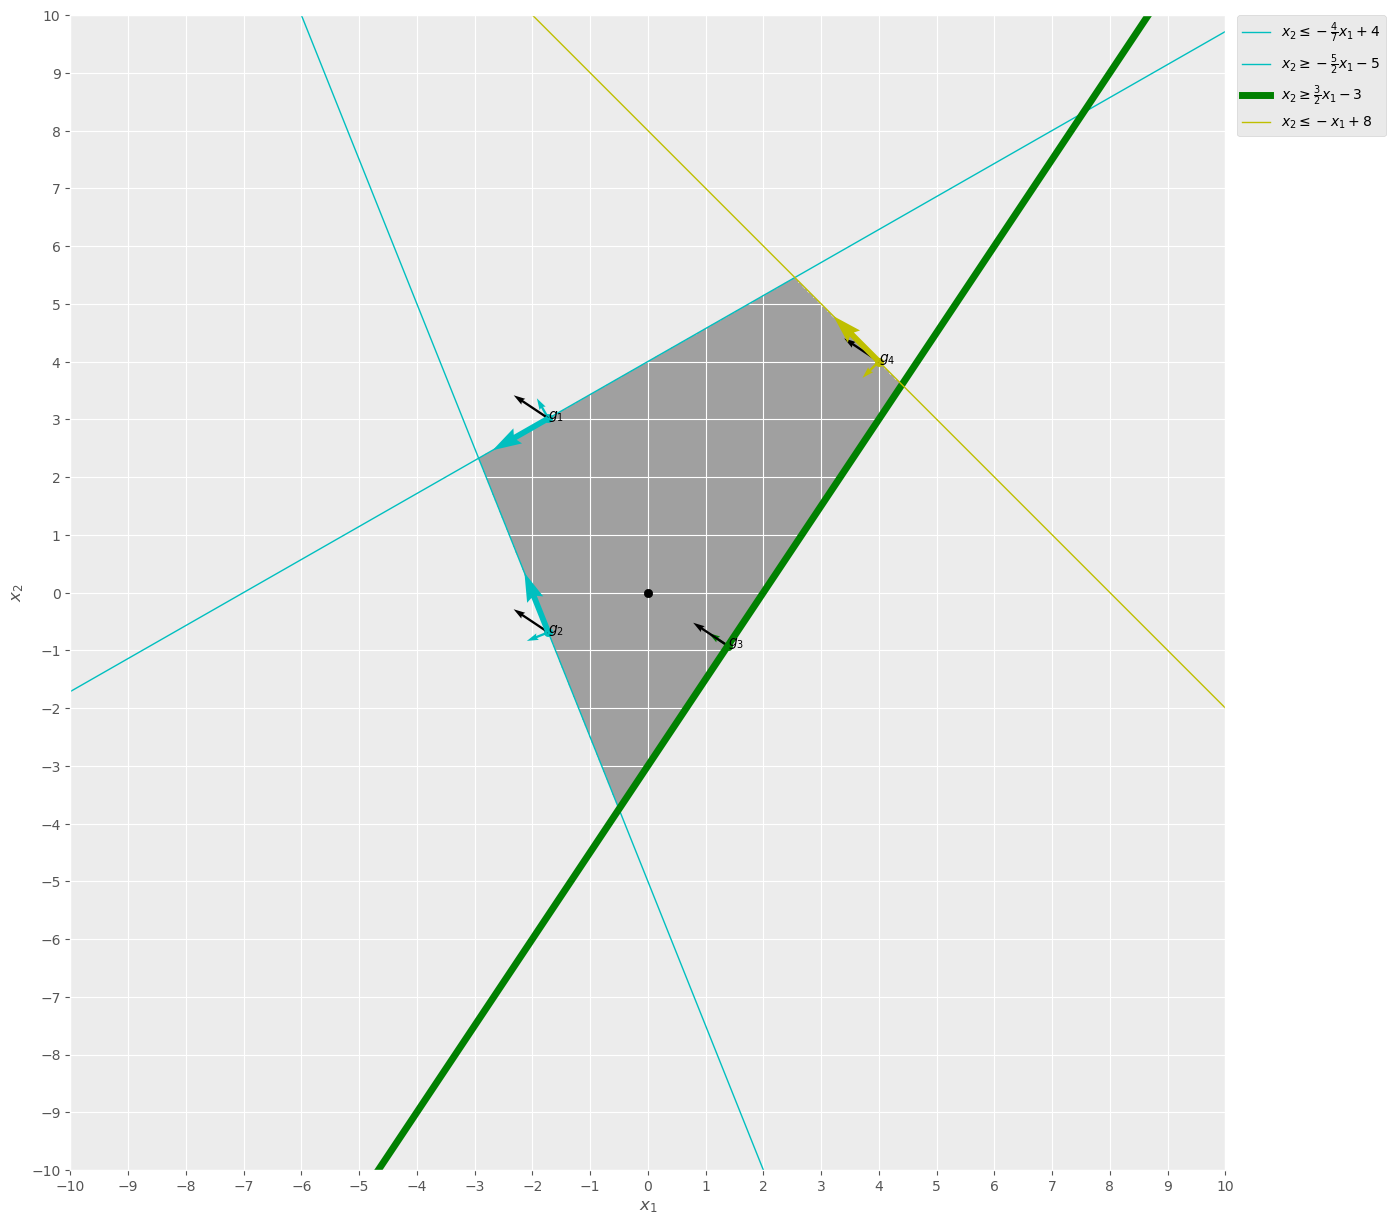

In [101]:
ybs=[
  ['(4/7)*x+4' ,   4, r'$x_2\leq-\frac{4}{7}x_1+4$', 'fy<=(4/7)*fx+4'],
  ['-(5/2)*x-5' , -5, r'$x_2\geq-\frac{5}{2}x_1-5$', 'fy>=-(5/2)*fx-5'],
  ['(3/2)*x-3' , -3, r'$x_2\geq\frac{3}{2}x_1-3$', 'fy>=(3/2)*fx-3'],
  ['-x+8'       ,  8, r'$x_2\leq-x_1+8$',            'fy<=-fx+8'],
]

ac   =0
acs  =[ac]*4

delz =np.array([-3,2]).reshape(2,1)
delzs=np.tile(delz,(4,1,1))

delgs=np.array([-4,7,-5,-2,-6,4,-1,-1]).reshape(4,2,1)
dvs  =np.array([[[v[1,0]],[-v[0,0]]] for v in delgs])

dds=[]
for a,b in list(zip(delzs,dvs)):
  dds.append(np.dot(a.flatten(),b.flatten()))

draw_LP(list(zip(ybs,delzs,delgs,dvs,dds)))

---

1

LP

$$
\begin{align*}
\max Z(\mathbf{x})&=-3x_1-6x_2+8\\
g_1(\mathbf{x})&=-3x_1-2x_2&&\le-6&&=b_1\\
g_2(\mathbf{x})&=5x_1-2x_2&&\le40&&=b_2\\
g_3(\mathbf{x})&=2x_1+4x_2&&\ge-8&&=b_3\\
g_4(\mathbf{x})&=x_1+x_2&&\le5&&=b_4\\
\end{align*}
$$

$
\begin{aligned}
g_1(\mathbf{x})&=-3x_1-2x_2&&\le-6&&=b_1&&\,\,\,\text{or}\,\,\,x_2\ge-\frac{3}{2}x_1+3\\
g_2(\mathbf{x})&=5x_1-2x_2&&\le40&&=b_2&&\,\,\,\text{or}\,\,\, x_2\ge\frac{5}{2}x_1-20\\
g_3(\mathbf{x})&=2x_1+4x_2&&\ge-8&&=b_3&&\,\,\,\text{or}\,\,\, x_2\ge-\frac{1}{2}x_1-2\\
g_4(\mathbf{x})&=x_1+x_2&&\le5&&=b_4&&\,\,\,\text{or}\,\,\, x_2\le-x_1+5\\
\end{aligned}
$

2

Objective function

$
Z(\mathbf{x})=-3x_1-6x_2+8
$

3

Gradient of the objective function

$
\nabla Z=
\begin{bmatrix}
-3 \\
-6 \\
\end{bmatrix}
$


4

Gradients of the linear constraints $\nabla g_i=\begin{bmatrix}c_1\\c_2\\\end{bmatrix}$

$
\begin{aligned}
\nabla g_1&=\begin{bmatrix}-3\\-2\\\end{bmatrix}\\
\nabla g_2&=\begin{bmatrix}5\\-2\\\end{bmatrix} \\
\nabla g_3&=\begin{bmatrix}2\\4\\\end{bmatrix} \\
\nabla g_4&=\begin{bmatrix}1\\1\\\end{bmatrix} \\
\end{aligned}
$

5

Direction vectors $\mathbf{v}_i=\begin{bmatrix}c_2\\-c_1\\\end{bmatrix}$

$
\begin{aligned}
\mathbf{v}_1&=\begin{bmatrix}-2\\3\\\end{bmatrix}&&\text{points NW}\\
\mathbf{v}_2&=\begin{bmatrix}-2\\-5\\\end{bmatrix}&&\text{points SW}\\
\mathbf{v}_3&=\begin{bmatrix}4\\-2\\\end{bmatrix}&&\text{points SE}\\
\mathbf{v}_4&=\begin{bmatrix}1\\-1\\\end{bmatrix}&&\text{points SE}\\
\end{aligned}
$

6

Direction of optimization

$
\begin{aligned}
\nabla Z\cdot\mathbf{v}_1&=-3\cdot-2-6\cdot3&&=-12&&\lt0&&\text{SE maximization}\\
\nabla Z\cdot\mathbf{v}_2&=-3\cdot-2-6\cdot-5&&=36&&\gt0&&\text{SW maximization}\\
\nabla Z\cdot\mathbf{v}_3&=-3\cdot4-6\cdot-2&&=0&&=0&&\text{level set}\\
\nabla Z\cdot\mathbf{v}_4&=-3\cdot1-6\cdot-1&&=3&&\gt0&&\text{SE maximization}\\
\end{aligned}
$

7

LP solution

Optimal set

argmax$_{\Gamma}(f)=\{x$ | $y=-\frac{1}{2}x-2,x\in[5,6]\}$

$
\arg\max_\Gamma(f)=\{\mathbf{x}\in\Gamma\mid \}
$

Optimal value

max$_{\Gamma}(f)=-3(5)-6(-4.5)+8=-15+27+8=20$

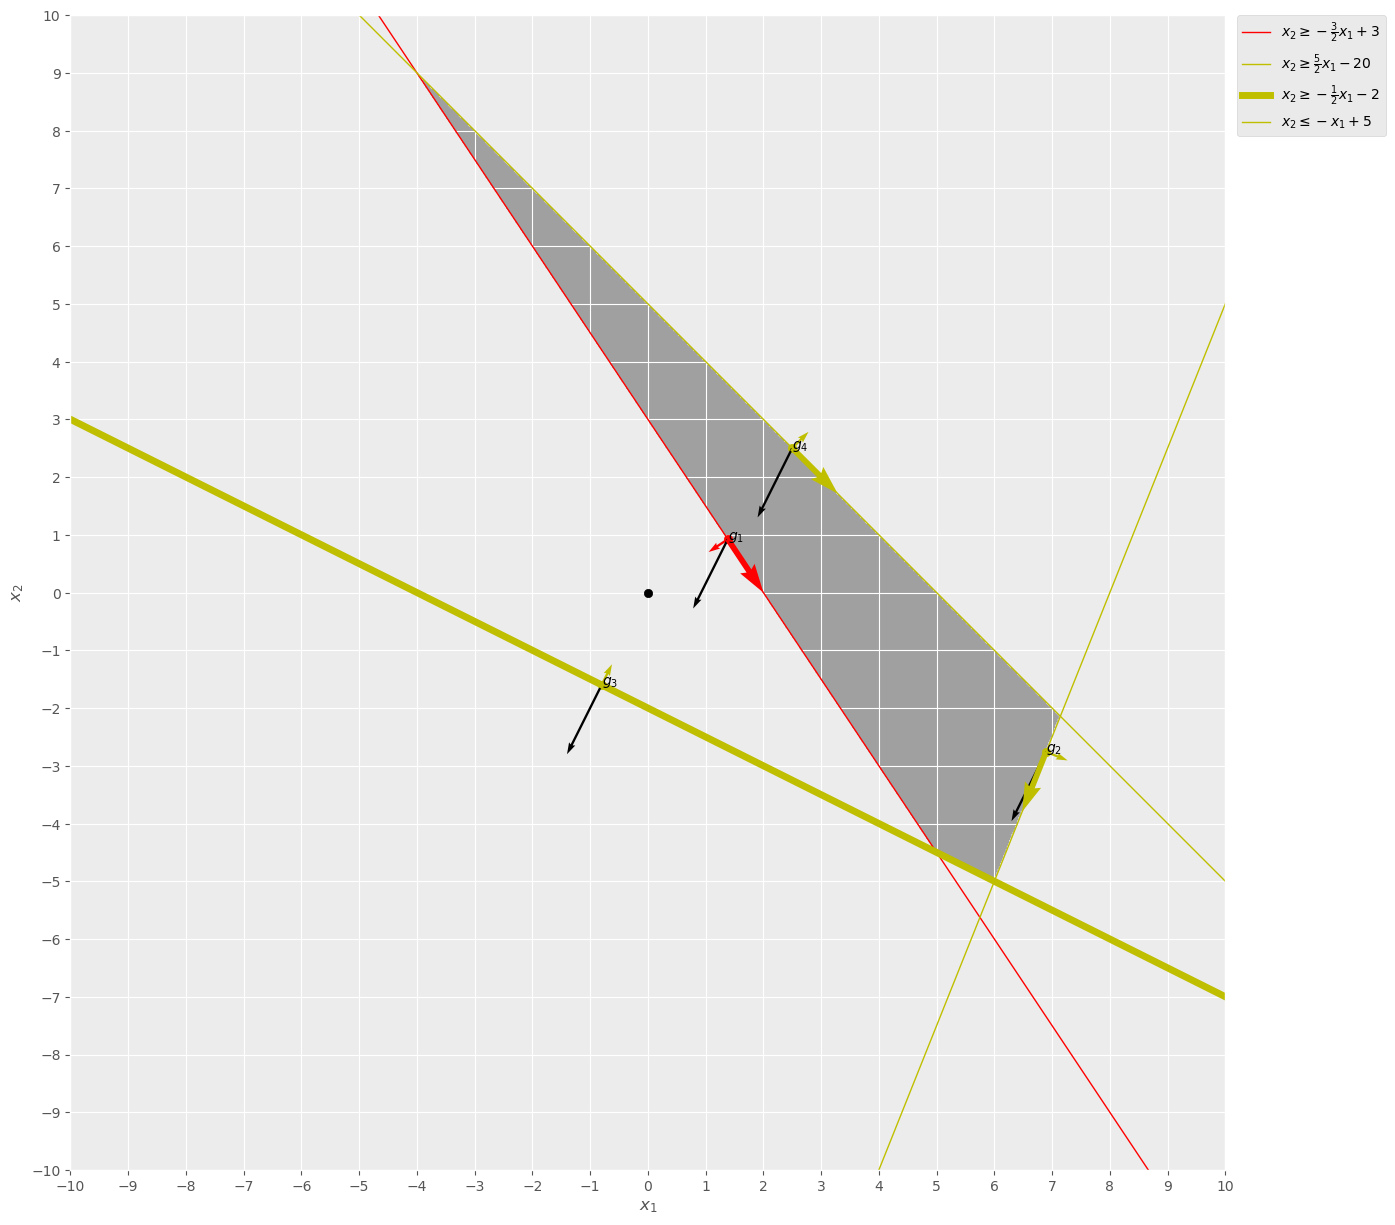

In [99]:
ybs=[
  ['-(3/2)*x+3' ,  3, r'$x_2\geq-\frac{3}{2}x_1+3$', 'fy>=-(3/2)*fx+3'],
  ['(5/2)*x-20' ,-20, r'$x_2\geq\frac{5}{2}x_1-20$', 'fy>=(5/2)*fx-20'],
  ['-(1/2)*x-2' ,- 2, r'$x_2\geq-\frac{1}{2}x_1-2$', 'fy>=-(1/2)*fx-2'],
  ['-x+5'       ,  5, r'$x_2\leq-x_1+5$',            'fy<=-fx+5'],
]

ac   =8
acs  =[ac]*4
delz =np.array([-3,-6]).reshape(2,1)
delzs=np.tile(delz,(4,1,1))
delgs=np.array([-3,-2,5,-2,2,4,1,1]).reshape(4,2,1)
dvs  =np.array([[[v[1,0]],[-v[0,0]]] for v in delgs])
dds=[]
for a,b in list(zip(delzs,dvs)):
  dds.append(np.dot(a.flatten(),b.flatten()))

draw_LP(list(zip(ybs,delzs,delgs,dvs,dds)))

---

The goal of an LP is to find the decision that optimizes some objective subject to certain constraints.

1.2 Def - LINEAR FUNCTION

A function $f : \mathbb{R}^n \rightarrow \mathbb{R}$ is linear if $f(ax + y) = af(x) + f(y) \,\,\, \forall{x, y} \in \mathbb{R}^n, \forall{a} \in \mathbb{R}$.

Note that if $f : \mathbb{R}^n \rightarrow \mathbb{R}$ is linear, then $f(\boldsymbol{0}) = 0$.

1.3 Def - AFFINE FUNCTION

A function $f : \mathbb{R}$ is affine if $f(x) = g(x) + c \,\,\, \forall{x} \in \mathbb{R}^n$ where $g$ is linear and $c \in \mathbb{R}$.

In other words, an affine function is just a linear function plus a constant.

1.4 Def - LINEAR CONSTRAINT

A linear constraint uses a linear function $f : \mathbb{R}^n \rightarrow \mathbb{R}$ and a constant $b \in \mathbb{R}$ to limit the values of a variable $x \in \mathbb{R}^n$ by requiring either $f(x) \le b$, $f(x) \ge b$, or $f(x) = b$.

Only weak inequalities are allowed, which makes the solution set closed.

Note that any affine constraint can be rewritten as a linear constraint.

1.5 Def - [LP] LINEAR PROGRAM

An LP is a problem of optimizing an affine function subject to finitely many linear constraints.

The function to be optimized is called the objective function.

Note that any affine objective function $f(x) + c$ attains its max (or min) where $f(x)$ attains its max (or min).

The constant $c$ only changes the optimal value of $f$, not the values of $x$ at which $f$ attains its maximum (or minimum).

1.6 Def - FEASIBLE SET

The feasible set of an LP is the set of all $x \in \mathbb{R}^n$ that satisfy all the constraints of the LP.

The feasible set may also be called the constraint set or the feasible region.

1.7,1.8 Def - OPTIMAL/SOLUTION SET

$\arg\max_{\Gamma}(f) = \{ x \in \Gamma \,\,\, | \,\,\, f(x) \ge f(y) \,\,\, \forall{y} \in \Gamma \}$

$\arg\max_{\Gamma}(f)$ is the set of points at which $f$ attains its maximum over the set $\Gamma$.

$\arg\min_{\Gamma}(f) = \{ x \in \Gamma \,\,\, | \,\,\, f(x) \le f(y) \,\,\, \forall{y} \in \Gamma \}$

$\arg\min_{\Gamma}(f)$ is the set of points at which $f$ attains its minimum over the set $\Gamma$.

If $\Gamma$ is the feasible set of an LP, then the optimal/solution set of the LP is $\argmax_{\Gamma}(f)$, if the LP is to maximize $f$, or $\argmin_{\Gamma}(f)$, if the LP is to minimize $f$.

1.9 Def - OPTIMAL VALUE

The optimal value of a maximization LP is $\text{max}_{\Gamma}(f)$ where $\Gamma$ is the feasible region of the LP.

The optimal value of a minimization LP is $\text{min}_{\Gamma}(f)$ where $\Gamma$ is the feasible region of the LP.

1.10 Def - LP SOLUTION

The solution to an LP consists of the optimal set and the optimal value.

In other words, solving an LP means finding both the optimal set and the optimal value.

1.11 Def - GRADIENT

Let $f : \mathbb{R}^n \rightarrow \mathbb{R}$. The gradient of $f$ is $\nabla{f} = \left( \frac{\partial f}{\partial x_1}, ..., \frac{\partial f}{\partial x_n} \right)$.

Note that if $f$ is linear or affine, then $\nabla{f}$ is constant.

The significance of the vector $\nabla{f}$ is that it points in the direction of the maximum rate of increase of $f$ per unit Euclidean distance change in the variable $x$ as it varies through $\mathbb{R}^n$.

1.12 Def - DIRECTIONAL DERIVATIVE

If $u \in \mathbb{R}^n$ is a nonzero vector and $f : \mathbb{R}^n \rightarrow \mathbb{R}$ is a function, then the directional derivative of $f$ in the direction of $u$ equals $\frac{\nabla{f} \cdot u}{||u||}$.

Note that the sign of the directional derivative does not depend on the magnitude of $u$. So $\nabla{f} \cdot u$ can be used in place of the true directional derivative when only the sign is needed. The sign is enough to tell whether $f$ increases $(\nabla{f} \cdot u \ge 0)$; decreases $(\nabla{f} \cdot u \le 0)$; or remains constant $(\nabla{f} \cdot u = 0)$ when the variable $x$ is changed in the direction of $u$.

Note also that because the gradient of an affine function is constant, the directional derivative in any direction is constant. (This will be relevant for step 2C of the graphical method.)

Does $f$ increase, decrease, or remain constant?
* $\nabla f\cdot \mathbf{u}\ge0\implies f$ increases in the direction of $\mathbf{u}$
* $\nabla f\cdot \mathbf{u}\le0\implies f$ decreases in the direction of $\mathbf{u}$
* $\nabla f\cdot \mathbf{u}=0\implies f$ remains constant in the direction of $\mathbf{u}$

1.13 Def - LEVEL SET ?????

If $f : \mathbb{R}^n \rightarrow \mathbb{R}$ a level set of $f$ is a subset of $\mathbb{R}^n$ on which $f$ has constant value $f(x) = b$ for some constant $b \in \mathbb{R}$, then $f(x) = b$ will sometimes be used as an abbreviation to refer to the level set $\{ x \in \mathbb{R}^n \,\,\, | \,\,\, f(x) = b \}$. (Whether the reference is to the equation itself or to the solution of the equation should be clear from the context.)

1.14 - ?????

If $f(x) = b$ on a set $S \in \mathbb{R}^n$ and $x, y \in S$ where $u = x - y$, then $\nabla{f} \cdot u = 0$.

That is, a function has zero directional derivative on any level set.

1.14.5 - using gradients to graph lines

The boundary of a linear inequality constraint in $\mathbb{R}^n$ is a hyperplane of dimension $n - 1$.
* In $\mathbb{R}^2$, a hyperplane of dimension $2 - 1 = 1$ is a line.
* In $\mathbb{R}^3$, a hyperplane of dimension $3 - 1 = 2$ is a plane.

The full solution of a linear equality constraint in $\mathbb{R}^n$ is a hyperplane of dimension $n - 1$.

A quick way to graph lines and an easy way to visually check one's graphs of lines in $\mathbb{R}^2$ is that the boundary of a linear constraint $f(x) \le b$ will be the line $f(x) = b$, a line perpendicular to $\nabla{f}$. Furthermore, $f(0) = 0$, so $\nabla{f}$ can be traced from the origin out to the level set $f(x) = b$.

For example,
* the boundary of the constraint $2x_1 + 3x_2 \le 6$ will be perpendicular to $\nabla{f} = (2, 3)$ and pass through the first quadrant with negative slope
* the boundary of the constraint $2x_1 - 3x_2 \le 6$ will be perpendicular to $\nabla{f} = (2, -3)$ and pass through the fourth quadrant with positive slope
* the boundary of the constraint $-2x_1 - 3x_2 \le 6$ will be perpendicular to $\nabla{f} = (-2, -3)$ and pass through the third quadrant with negative slope
* the boundary of the constraint $-2x_1 + 3x_2 \le 6$ will be perpendicular to $\nabla{f} = (-2, 3)$ and pass through the second quadrant with positive slope

Gradients also make it easy to check which side of an inequality is the feasible side (i.e., the side that satisfies the constraint.)
* the feasible side of the boundary of $f(x) \ge b$ is the side that $\nabla{f}$ points to
* the feasible side of the boundary of $f(x) \le b$ is the opposite side from what $\nabla{f}$ points to (i.e., the side $-\nabla{f}$ points to)
* the feasible set of $f(x) = b$ is just the line itself

1.15 - graphing feasible sets



---

objective function: the affine function to optimize
LP: to optimize the objective function subject to finitely many linear constraints

$\Gamma$ feasible set

$\arg\max_{\Gamma}(f)$ optimal set

$\max_{\Gamma}(f)$ optimal value

## 6 Matrix Forms

1

$
\begin{aligned}
\text{max} \,\,\, & cx+d \\
Ax &\ge b \\
x &\ge 0 \\
\end{aligned}
$

2

$
\begin{aligned}
\text{max} \,\,\, & cx+d \\
Ax&\le b \\
x&\ge0
\end{aligned}
$

3

$
\begin{aligned}
\text{max} \,\,\, & cx+d \\
Ax&= b \\
x&\ge0
\end{aligned}
$

4

$
\begin{aligned}
\text{min} \,\,\, & cx+d \\
Ax &\ge b \\
x &\ge 0 \\
\end{aligned}
$

5

$
\begin{aligned}
\text{min} \,\,\, & cx+d \\
Ax&\le b \\
x&\ge0
\end{aligned}
$

6

$
\begin{aligned}
\text{min} \,\,\, & cx+d \\
Ax&= b \\
x&\ge0
\end{aligned}
$

---

## Class Notes

### 02/06 Monday

concise tableau

$
\begin{bmatrix}
u_1&u_2&u_3&u_4&1\\
-1&1&-4&4&40&s_1\\
-2&2&2&-2&-12&s_2\\
3&-3&1&-1&15&s_3\\
4&-4&-3&3&5&z\\
\end{bmatrix}
$

### 02/03 Friday

parallel constraints leads to dependent slack variables, which come from depedent constraint functions due to parallel lines

$
g_1=x_1+x_2\ge-4=b_1\\
g_2=x_1+x_2\le4=b_2\\
x_1-x_2\ge-8\\
x_1-x_2\le8\\
$

$
g_1-s_1=-4\\
g_2+s_2=4\\
$

$
s_1=g_1+4\\
s_2=-g_2+4\\
$

but $g_1=g_2$ so $s_1+s_2=8$

example starting from visualization

$
\nabla g_1=(1,4)\\
\nabla g_2=(-2,2)\\
\nabla g_3=(-3,-1)\\
\nabla Z=(4,-3)\\
$

$u\cdot v=||u||||v||\cos\theta$

$
\begin{aligned}
\min Z&=4x_1-3x_2+5\\
x_1+4x_2&\le40\\
-2x_1+2x_2&\ge12\\
-3x_1-x_2&\le15\\
\end{aligned}
$

$
\begin{aligned}
x_1&=u_1-u_2\\
x_2&=u_3-u_4\\
\end{aligned}
$

extended tableau

$
\begin{aligned}
u_1&&u_2&&u_3&&u_4&&s_1&&s_2&&s_3&&Z&&RHS\\
1&&-1&&4&&-4&&1&&0&&0&&0&&40\\
2&&-2&&-2&&2&&0&&1&&0&&0&&-12\\
-3&&3&&-1&&1&&0&&0&&1&&0&&15\\
-4&&4&&3&&-3&&0&&0&&0&&1&&5\\
\end{aligned}
$

the basic solution to a given tableau means:
1. set the non basic variables to zero
2. set the basic variables to the constants (the right hand side) to solve the system (the tableau represents a system of equations) (the basic variables are the ones with the basis vectors under it in the extended tableau, except the objective variable Z)

set $u_1=u_2=u_3=u_4=0$

$s_1=40,s_2=-12,s_3=15,Z=5$

the initial tableau always maps to the origin

pivot

$
\begin{aligned}
u_1&&u_2&&u_3&&u_4&&s_1&&s_2&&s_3&&Z&&RHS\\
\frac{1}{4}&&-\frac{1}{4}&&1&&-1&&\frac{1}{4}&&0&&0&&0&&10\\
\frac{5}{2}&&-\frac{5}{2}&&0&&0&&\frac{1}{2}&&1&&0&&0&&8\\
?&&?&&0&&?&&?&&?&&?&&?&&?\\
?&&?&&0&&?&&?&&?&&?&&?&&?\\
\end{aligned}
$

### 02/01 Wednesday

$
\begin{aligned}
\min z&=-6x_1+3x_2+5\\
x_1+2x_2&\le6\\
-4x_1+5x_2&\ge-20\\
7x_1-8x_2&\le35\\
-9x_1-10x_2&=36
\end{aligned}
$

a free variable is a variable that can be positive or negative

free variable subsitution allows us to represent free variables with nonnegative variables

$
\begin{aligned}
x_1&=u_1-u_2\\
x_2&=u_3-u_4\\
u&\ge0\\
\end{aligned}
$

$
\begin{aligned}
z&=-6u_1+6u_2+3u_3-3u_4+5\\
u_1-u_2+2u_3-2u_4&\le6\\
-4u_1+4u_2+5u_3-5u_4&\ge-20\\
7u_1-7u_2-8u_3+8u_4&\le35\\
-9u_1+9u_2-10u_3+10u_4&=36\\
u&\ge0\\
\end{aligned}
$

$
Ax=b\implies
\begin{bmatrix}
1&-1&2&-2&1&0&0&0&0\\
-4&4&5&-5&0&-1&0&0&0\\
7&-7&-8&8&0&0&1&0&0\\
-9&9&-10&10&0&0&0&1&0\\
-9&9&-10&10&0&0&0&0&-1\\
\end{bmatrix}
\begin{bmatrix}
u_1\\u_2\\u_3\\u_4\\s_1\\s_2\\s_3\\s_4\\s_5\\
\end{bmatrix}=
\begin{bmatrix}
6\\-20\\35\\36\\36\\
\end{bmatrix}
$

$
z=cx+d\implies
\begin{bmatrix}
-6&6&3&-3&0&0&0&0&0\\
\end{bmatrix}
\begin{bmatrix}
u_1\\u_2\\u_3\\u_4\\s_1\\s_2\\s_3\\s_4\\s_5\\
\end{bmatrix}+
5
$

$
\min cx+d\\
Ax=b\\
x\ge0\\
$

$
Ax=b\implies
\begin{bmatrix}
1&-1&2&-2&1&0&0&0&0\\
4&-4&-5&5&0&1&0&0&0\\
7&-7&-8&8&0&0&1&0&0\\
-9&9&-10&10&0&0&0&1&0\\
9&-9&10&-10&0&0&0&0&1\\
\end{bmatrix}
\begin{bmatrix}
u_1\\u_2\\u_3\\u_4\\s_1\\s_2\\s_3\\s_4\\s_5\\
\end{bmatrix}=
\begin{bmatrix}
6\\20\\35\\36\\-36\\
\end{bmatrix}
$

$g_1(x)\ge b_1$ iff $g_1(x)-s=b_1$ where $s_1\ge0$

$s_1=g_1(x)-b_1$ slack for a greater than or equal to constraint

$g_2(x)\le b_2$ iff $g_2(x)+s=b_2$ where $s_2\ge0$

$s_2=b_2-g_2(x)$ slack for a less than or equal to constraint

at the origin, $s_1=6,s_2=20,s_3=35,s_4=36,s_5=-36$

at (0,3), $s_1=0,s_2=35,s_3=59,s_4=66,s_5=-36$

Extended Tableau Form

$-cx+z=d$

$
\begin{matrix}
u_1&u_2&u_3&u_4&s_1&s_2&s_3&s_4&s_5&z&\text{right-hand side}\\
1&-1&2&-2&1&0&0&0&0&0&6\\
4&-4&-5&5&0&1&0&0&0&0&20\\
7&-7&-8&8&0&0&1&0&0&0&35\\
-9&9&-10&10&0&0&0&1&0&0&36\\
9&-9&10&-10&0&0&0&0&1&0&-36\\
6&-6&-3&3&0&0&0&0&0&1&5\\
\end{matrix}
$

at first
* basic variables $s_i$ are slack variables
* nonbasic variables $u_i$ are control variables

### 01/30 Monday

$
\min -6x_1+3x_2+5 \\
\begin{aligned}
x_1+2x_2&\le6 \\
-4x_1+5x_2&\ge-20 \\
7x_1-8x_2&\le35 \\
-9x_1-10x_2&=36 \\
\end{aligned}
$

define A,b,c,d,x s.t. the matrix form is equivalent to the given LP
$
\begin{aligned}
\text{min} \,\,\, & cx+d \\
Ax &\le b \\
x &\ge 0 \\
\end{aligned}
$

$
c=(-6,3),d=5,x=\begin{bmatrix}x_1\\x_2\\\end{bmatrix}
$

$
\min -6x_1+3x_2+5 \\
\begin{aligned}
x_1+2x_2&\le6 \\
4x_1-5x_2&\le20 \\
7x_1-8x_2&\le35 \\
-9x_1-10x_2&\le36 \\
9x_1+10x_2&\le-36 \\
\end{aligned}
$

$r=s\iff r\le s\land r\ge s$

$
\begin{bmatrix}
1&2\\
4&-5\\
7&-8\\
-9&-10\\
9&10\\
\end{bmatrix}
\begin{bmatrix}
x_1\\
x_2\\
\end{bmatrix}
\le
\begin{bmatrix}
6\\20\\35\\36\\-36\\
\end{bmatrix}
$

$
Ax=b
$

* Find the min by finding the max of the negative
* Find the max by finding the min of the negative

max(-f)=-min(-f)

-max(-f)=min(f)

argmin(f)=argmax(-f)

$
\max\begin{bmatrix}6&-3\\\end{bmatrix}\begin{bmatrix}x_1\\x_2\\\end{bmatrix}-5=-Z
$


follows from linearity

if $f:\mathbb{R}^n\rightarrow\mathbb{R}$ is linear then $\exists c\in\mathbb{R}^n$ s.t. $\forall x\in\mathbb{R}^n,f(x)=c\cdot x$

let $\{e_1,...,e_n\}$ be the standard basis $e_1=(1,0,...,0),e_2=(0,1,0,...,0)$

$x=(x_1,...,x_n)=\sum_{i=1}^n x_ie_i$

$f(x)=f(\sum x_ie_i)=\sum x_i f(e_i)=x_1f(e_1)+x_2f(e_2)+...+x_nf(e_n)$

$f(x)=x\cdot(f(e_1)f(e_2)...f(e_n))=x\cdot\nabla f$

every equation reduces the dimension of the solution set

an inequality does not reduce dimensionality (just a half plane)

$x_1+2x_2+s_1=6$ where $s_1$ is the slack variable

$s_1\ge0$

second constraint $4x_1-5x_2+s_2=20,s_2\ge0$

$
A=
\begin{bmatrix}
1&2&1&0&0&0&0\\
4&-5&0&1&0&0&0\\
7&-8&0&0&1&0&0\\
-9&-10&0&0&0&1&0\\
9&10&0&0&0&0&1\\
\end{bmatrix}
$

$
x=\begin{bmatrix}x_1\\x_2\\s_1\\s_2\\s_3\\s_4\\s_5\end{bmatrix}
$

### 01/27 Friday

a point that has a unique representation

$c_1x_1+c_2x_2+...+c_kx_k$ is convex where $c_i\gt 0$ and $\sum c_i=1$

$x_1,...,x_k\in S$

$y_1=\frac{c_1}{c_1+c_2}x_1+\frac{c_2}{c_1+c_2}x_2\in S$

$(c_1+c_2)y+c_3x_3+...+c_kx_k$

convex hull

$\{\sum_{i=1}^k c_ix_i \,\,\, | \,\,\, c \ge 0 \sum x_i = 1\}$ the smallest convex set containing ${x_1,...,x_k}$

### 01/23 MONDAY

roadmap
* convexity (today)
* matrix forms: packaging the LP
* tableau form (the simplex algorithm uses this)
* final forms: infeasible, feasible but unbounded, feasible
* mapping tableau in control variables
* simplex algorithm

$S \sub \mathbb{R}^n$ is convex if $\forall x,y \in S$ and $\alpha\in[0,1], \alpha x+(1-\alpha)y\in S$

convex combination of x and y

linear combination if coeffs are 0 and sum of coeffs are 1

convex combination of $\{x_1,...,x_k\}$ (a set of vectors) is $\sum c_ix_i$ s.t. $c_i \ge 0,i=1,...k$ and $\sum^k_{i=1} c_i=1$

$x_1 \in \mathbb{R}^n,x_2\in\mathbb{R}^n,...,x_k\in\mathbb{R}^n$

$\alpha\le 1\rightarrow 1-\alpha\ge 0$

geometrically a set $S$ is convex iff $\forall x,y\in S$ the line segment connecting x and y is entirely in S

the empty set is convex

$g(x)\ge b$ where $g:\mathbb{R}^n\rightarrow\mathbb{R}$ is linear

x is generic

suppose y and z are feasible i.e. $g(y)\ge b$ and $g(z)\ge b$

y and z are two specific points that pass the constraint

we need to show that $g(\alpha y+(1-\alpha)z)\ge b \forall\alpha\in [0,1]$

g is linear therefore $\alpha g(y)+(1-\alpha)g(z) \ge \alpha b + (1-\alpha)b = b$

$\alpha g(y) \ge \alpha b$

$(1-\alpha)g(z) \ge (1-\alpha)b$

---

## Linear Map/Transformation

A linear map is a map $V\rightarrow W$ between two vector spaces that preserves the operations of vector addition and scalar multiplication.

Let $V,W$ be vector spaces over the same field $K$. A function $f:V\rightarrow W$ is said to be a linear map if for any two vectors $\mathbf{u},\mathbf{v}\in V$ and any scalar $c\in K$ the following two conditions are satisfied:
1. Additivity $f(\mathbf{u}+\mathbf{v})=f(\mathbf{u})+f(\mathbf{v})$
2. Homogeneity of degree 1 (scalar multiplication) $f(c\mathbf{u})=cf(\mathbf{u})$

A linear map is said to be operation preserving becuase it does not matter whether the linear map is applied before or after the operations of addition and scalar multiplication.

A linear map preserves linear combinations: $f(c_1\mathbf{u}_1+...+c_n\mathbf{u}_n)=c_1f(\mathbf{u}_1)+...+c_nf(\mathbf{u}_n)\,\,\,\forall \mathbf{u}_1,...,\mathbf{u}_n\in V,\forall c_1,...,c_n\in K$ by the associativity of the addition operation

$f(\boldsymbol{0}_V)=f(0\mathbf{v})=0f(\mathbf{v})=\boldsymbol{0}_W$

If a linear map is a bijection, then it is called a linear isomorphism.

In the case where $V=W$, then a linear map is called a linear endomorphism.

A linear map $V\rightarrow W$ always maps the origin of $V$ to the origin of $W$.

A linear map $V\rightarrow W$ maps linear subspaces in $V$ onto linear subspaces in $W$ (possibly of lower dimension).

Linear maps can be represented as matrices.

Rotation

Reflection

---

## Affine Transformation

An affine transformation is a geometric transformation that preserves lines and parallelism but not necessarily Euclidean distances and angles.

Affine Transformations
* Scaling
* Reflection
* Rotation

---

## Terms

* Affine Function
* [Affine Space](https://en.wikipedia.org/wiki/Affine_space)
* [Affine Transformation](https://en.wikipedia.org/wiki/Affine_transformation)
* [Ambient Space](https://en.wikipedia.org/wiki/Ambient_space)
* [Antiderivative](https://en.wikipedia.org/wiki/Antiderivative)
* [Calculus](https://en.wikipedia.org/wiki/Calculus)
* Constraint
* [Curl](https://en.wikipedia.org/wiki/Curl_(mathematics))
* [Curve](https://en.wikipedia.org/wiki/Curve)
* [Derivative](https://en.wikipedia.org/wiki/Derivative)
* [Differentiable Curve](https://en.wikipedia.org/wiki/Differentiable_curve)
* [Differentiable Function](https://en.wikipedia.org/wiki/Differentiable_function)
* [Differential Calculus](https://en.wikipedia.org/wiki/Differential_calculus)
* [Divergence](https://en.wikipedia.org/wiki/Divergence)
* [Equation](https://en.wikipedia.org/wiki/Equation)
* [Euclidean Plane](https://en.wikipedia.org/wiki/Euclidean_plane)
* [Euclidean Plane Isometry](https://en.wikipedia.org/wiki/Euclidean_plane_isometry)
* [Euclidean Space](https://en.wikipedia.org/wiki/Euclidean_space)
* [Expression](https://en.wikipedia.org/wiki/Expression_(mathematics))
* [Function](https://en.wikipedia.org/wiki/Function_(mathematics))
* [Fundamental Theorem of Algebra](https://en.wikipedia.org/wiki/Fundamental_theorem_of_algebra)
* [Fundamental Theorem of Calculus](https://en.wikipedia.org/wiki/Fundamental_theorem_of_calculus)
* [Geometric Transformation](https://en.wikipedia.org/wiki/Geometric_transformation)
* [Glide Reflection](https://en.wikipedia.org/wiki/Glide_reflection)
* [Gradient](https://en.wikipedia.org/wiki/Gradient)
* [Homothety](https://en.wikipedia.org/wiki/Homothety)
* [Hyperplane](https://en.wikipedia.org/wiki/Hyperplane)
* [Infinitesimal](https://en.wikipedia.org/wiki/Infinitesimal)
* [Integral](https://en.wikipedia.org/wiki/Integral)
* [Isometry](https://en.wikipedia.org/wiki/Isometry)
* [Level Curve (Contour Line, Isoline)](https://en.wikipedia.org/wiki/Contour_line)
* Level Hypersurface
* [Level Set](https://en.wikipedia.org/wiki/Level_set)
* [Level Surface (Isosurface)](https://en.wikipedia.org/wiki/Isosurface)
* [Line Integral](https://en.wikipedia.org/wiki/Line_integral)
* [Linear Map/Transformation](https://en.wikipedia.org/wiki/Linear_map)
* Linear Constraint
* Linear Program (LP)
* [Loss Function](https://en.wikipedia.org/wiki/Loss_function)
* [Map](https://en.wikipedia.org/wiki/Map_(mathematics))
* Mathematical Model
* [Multiple Integral](https://en.wikipedia.org/wiki/Multiple_integral)
* [Multivariable Calculus](https://en.wikipedia.org/wiki/Multivariable_calculus)
* [Multivariate Function (Function of Several Variables)](https://en.wikipedia.org/wiki/Function_(mathematics)#Multivariate_function)
* Objective Function
* [Plane](https://en.wikipedia.org/wiki/Plane_(geometry))
* [Polynomial](https://en.wikipedia.org/wiki/Polynomial)
* [Reflection](https://en.wikipedia.org/wiki/Reflection_(mathematics))
* [Rotation](https://en.wikipedia.org/wiki/Rotation_(mathematics))
* [Rotations and reflections in two dimensions](https://en.wikipedia.org/wiki/Rotations_and_reflections_in_two_dimensions)
* [Scalar Field](https://en.wikipedia.org/wiki/Scalar_field)
* [Scaling](https://en.wikipedia.org/wiki/Scaling_(geometry))
* [Shearing](https://en.wikipedia.org/wiki/Shear_mapping)
* [Similarity](https://en.wikipedia.org/wiki/Similarity_(geometry))
* [Smoothness](https://en.wikipedia.org/wiki/Smoothness)
* [Surface](https://en.wikipedia.org/wiki/Surface_(mathematics))
* [Surface Integral](https://en.wikipedia.org/wiki/Surface_integral)
* [Symmetry Operation](https://en.wikipedia.org/wiki/Symmetry_operation)
* [Translation](https://en.wikipedia.org/wiki/Translation_(geometry))
* [Vector](https://en.wikipedia.org/wiki/Euclidean_vector)
* [Vector Calculus](https://en.wikipedia.org/wiki/Vector_calculus)
* [Vector Field](https://en.wikipedia.org/wiki/Vector_field)
* [Vector-Valued Function](https://en.wikipedia.org/wiki/Vector-valued_function)

---